In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from itertools import combinations
from efficient_apriori import apriori
import pyfpgrowth as fpg
from datetime import datetime

## Import Dataset

In [ ]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__train = pd.read_csv('order_products__train.csv')

## Exploring Dataset

In [ ]:
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
order_products__prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
order_products__train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Total Records in each table

In [ ]:
count = np.array([['Aisles',len(aisles)],
                        ['Departments', len(departments)],
                        ['Products',len(products)],
                        ['Orders',len(orders)],
                        ['Order_Products__Prior',len(order_products__prior)],
                        ['Order_Products__Train',len(order_products__train)]])
countRecord = pd.DataFrame(count)
countRecord

,Table,Total Records
0,Aisles,134
1,Department,21
2,Product,49688
3,Order,3421083
4,Order_Product_Prior,32434489
5,Order_Product_Train,1384617


### Total Records or orders by Eval Type in Orders

In [ ]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

## Data Cleaning

### Check for Missing Values

In [ ]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [ ]:
departments.isna().sum()

department_id    0
department       0
dtype: int64

In [ ]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [ ]:
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [ ]:
order_products__prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [ ]:
order_products__train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Feature Extraction and Creation

### Merge Order_Product_Prior with Order, Product, Department and Aisles

In [ ]:
order_products__prior = order_products__prior.merge(orders, on = 'order_id', how = 'left')
order_products__prior = order_products__prior.merge(products, on = 'product_id', how = 'left')
order_products__prior = order_products__prior.merge(aisles, on = 'aisle_id', how = 'left')
order_products__prior = order_products__prior.merge(departments, on = 'department_id', how = 'left')

In [ ]:
order_products__prior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4,fresh vegetables,produce
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


### Merge Order_Product_Train with Order, Product, Department and Aisles

In [ ]:
order_products__train = order_products__train.merge(orders, on = 'order_id', how = 'left')
order_products__train = order_products__train.merge(products, on = 'product_id', how = 'left')
order_products__train = order_products__train.merge(aisles, on = 'aisle_id', how = 'left')
order_products__train = order_products__train.merge(departments, on = 'department_id', how = 'left')

In [ ]:
order_products__train.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
5,1,13176,6,0,112108,train,4,4,10,9.0,Bag of Organic Bananas,24,4,fresh fruits,produce
6,1,47209,7,0,112108,train,4,4,10,9.0,Organic Hass Avocado,24,4,fresh fruits,produce
7,1,22035,8,1,112108,train,4,4,10,9.0,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs
8,36,39612,1,0,79431,train,23,6,18,30.0,Grated Pecorino Romano Cheese,2,16,specialty cheeses,dairy eggs
9,36,19660,2,1,79431,train,23,6,18,30.0,Spring Water,115,7,water seltzer sparkling water,beverages


### Feature set creation for Apriori and FP-Growth

In [ ]:
groupingOrders = pd.DataFrame(order_products__prior.groupby('order_id')['product_id'])

In [ ]:
order1 = groupingOrders[0]
product = []

for i in range(len(groupingOrders[0])):
    product.append(list(groupingOrders.iloc[i][1]))
product1 = product
transaction = pd.DataFrame({'OrderID' : order1, 'Products' : product1})

In [ ]:
transaction.head(10)

,OrderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


# Data Analysis

### Maximum Order Number by a customer and it's frequency

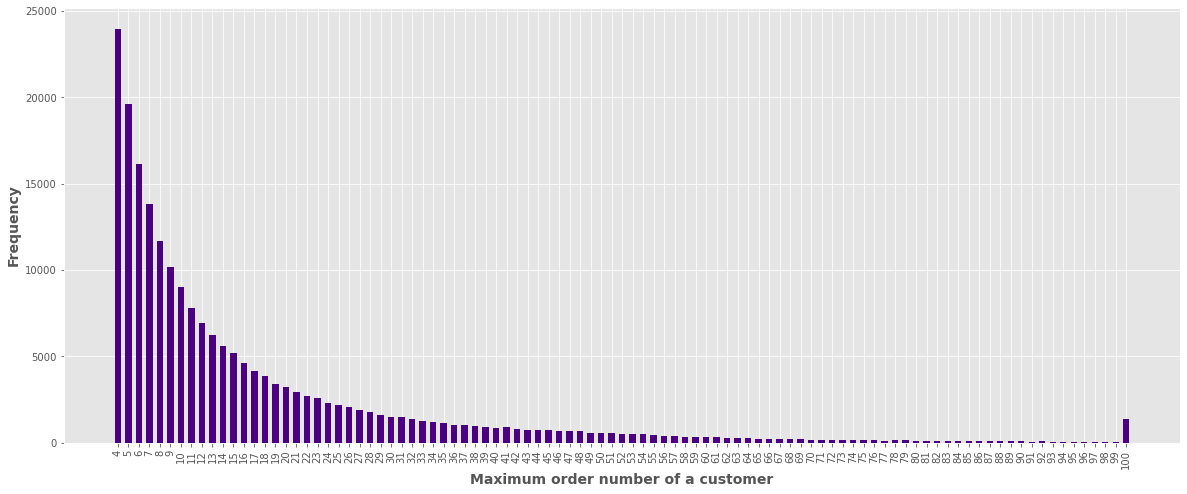

In [ ]:
maximum_count_order = orders.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
maximum_count_order = maximum_count_order.order_number.value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(20,8))
plt.bar(maximum_count_order.index, maximum_count_order.values, width = 0.6)
plt.xticks(maximum_count_order.index,rotation='vertical')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.xlabel('Maximum order number of a customer', fontsize = 14, fontweight = 'bold')
plt.show()

### Order frequencies with day of the week

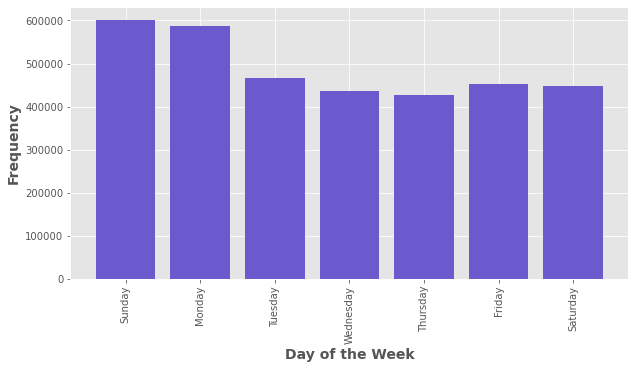

In [ ]:
xAxis=[0,1,2,3,4,5,6]
yAxis=[orders[orders['order_dow']==0].shape[0],orders[orders['order_dow']==1].shape[0],orders[orders['order_dow']==2].shape[0],
    orders[orders['order_dow']==3].shape[0],orders[orders['order_dow']==4].shape[0],orders[orders['order_dow']==5].shape[0],orders[orders['order_dow']==6].shape[0]]
plt.figure(figsize = (10,5))
plt.bar(xAxis,yAxis, color='slateblue')
plt.xlabel('Day of the Week', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.xticks(xAxis,['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], rotation = 'vertical')
plt.show()

### Order frequencies with hour of the day

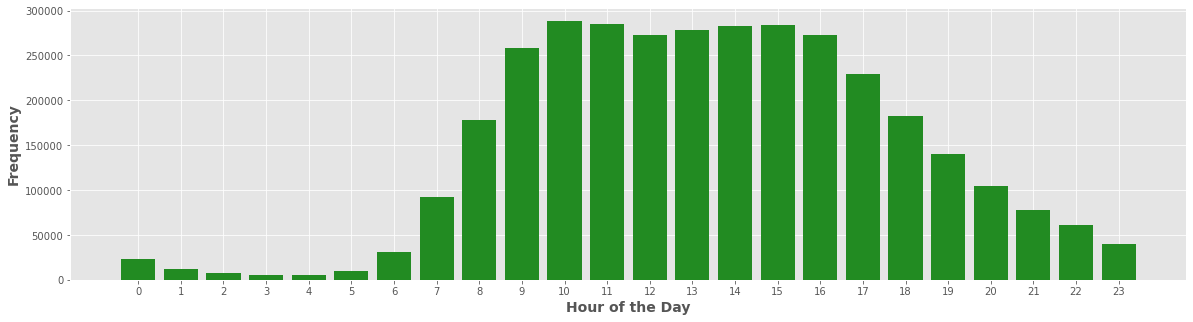

In [ ]:
xAxis= list(range(0,24))
yAxis=[]
for i in range(24):
    yAxis.append(orders[orders['order_hour_of_day']==i].shape[0])
plt.figure(figsize=(20,5))
plt.bar(xAxis,yAxis,color='forestgreen')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hour of the Day', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.show()

### Department and it's order frequency

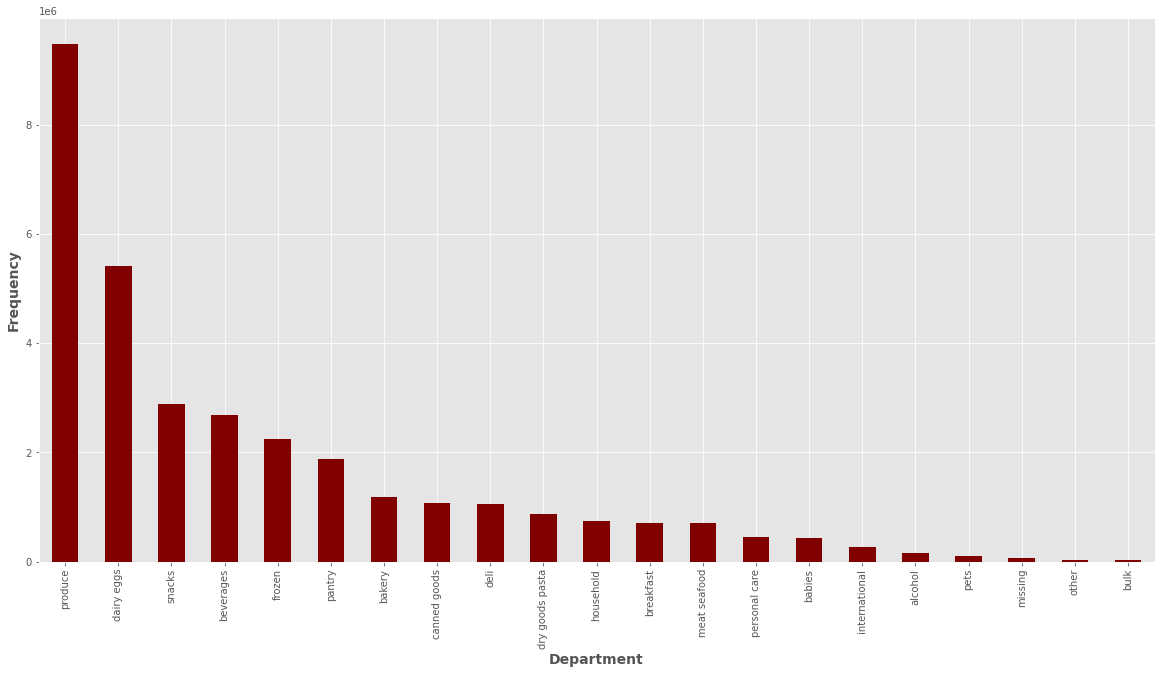

In [ ]:
count_dept = order_products__prior['department'].value_counts()
figure = plt.figure(figsize = (20,10))
count_dept.plot(kind="bar", color='maroon')
plt.xticks(rotation = 90)
plt.xlabel('Department', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.show()

### Top 20 Aisles and it's order frequency

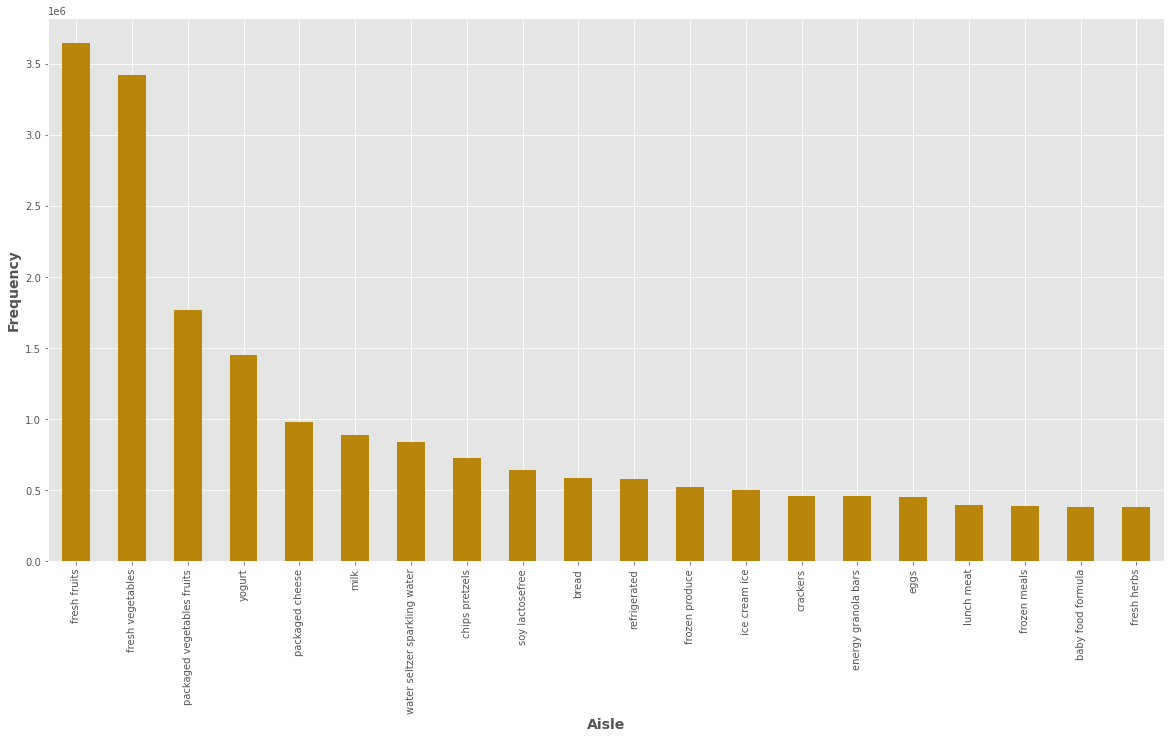

In [ ]:
count_Aisles = order_products__prior['aisle'].value_counts()
figure = plt.figure(figsize = (20,10))
count_Aisles[0:20].plot(kind="bar", color='darkgoldenrod')
plt.xticks(rotation = 90)
plt.xlabel('Aisle', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.show()

### Top 20 Product and it's order frequency

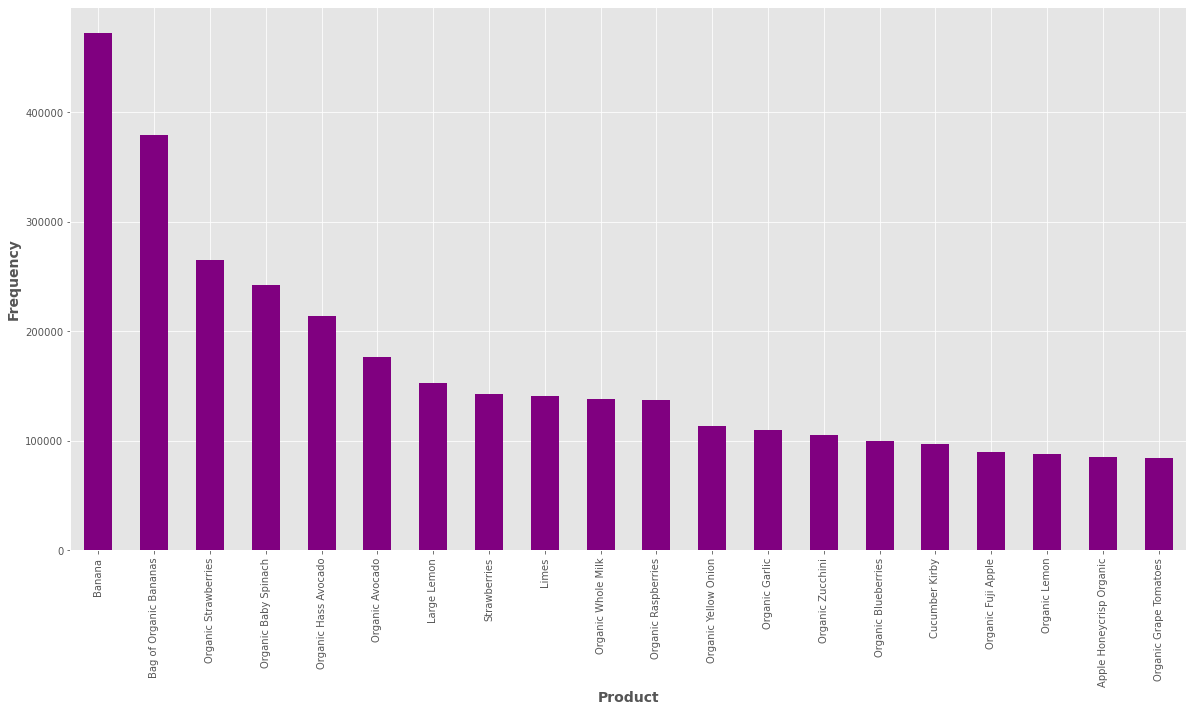

In [ ]:
count_product = order_products__prior['product_name'].value_counts()
figure = plt.figure(figsize = (20,10))
count_product[0:20].plot(kind="bar", color='purple')
plt.xticks(rotation = 90)
plt.xlabel('Product', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.show()

## Analysis of Re-orders

In [ ]:
DFtemporary = order_products__prior.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
DFtemporary = DFtemporary.sort_values('total', ascending=False).reset_index()

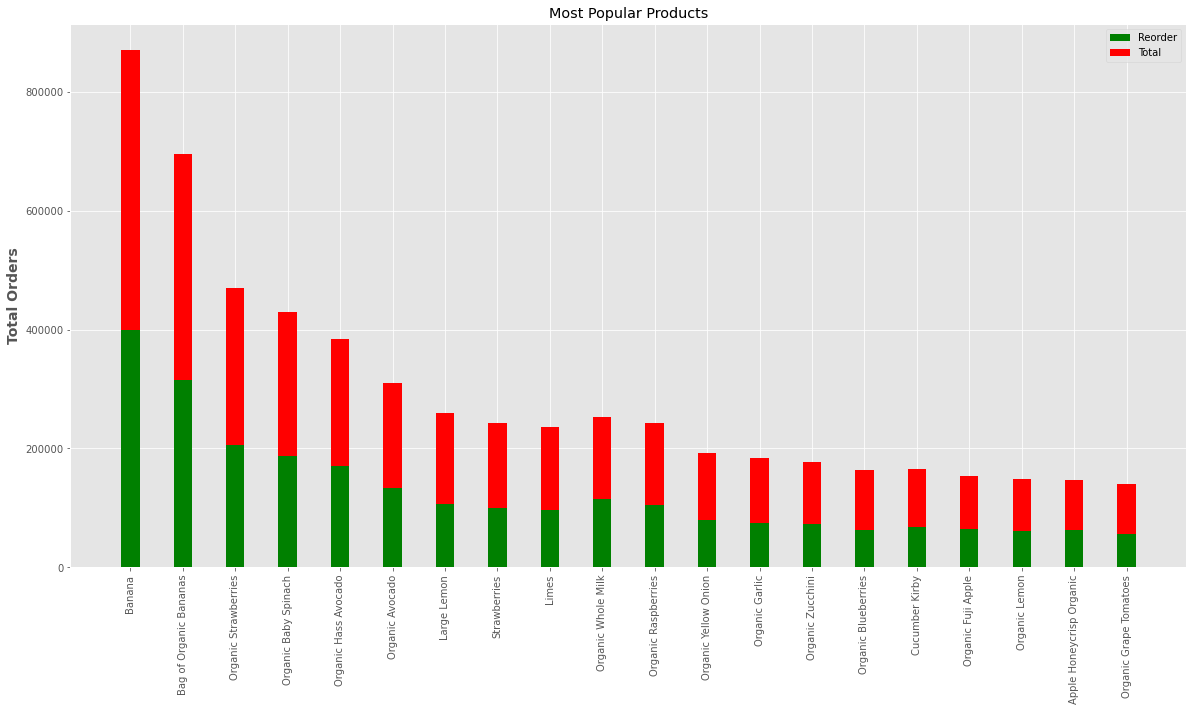

In [ ]:
Label = list(DFtemporary.product_name[0:20])
ReOrders = list(DFtemporary.reorders[0:20])
TotalReOrder = list(DFtemporary.total[0:20])
Width = 0.35       # the width of the bars: can also be len(x) sequence

figure, axis = plt.subplots(figsize = (20,10))
axis.bar(Label, ReOrders, Width, label='Reorder',color='green')
axis.bar(Label, TotalReOrder, Width, bottom=ReOrders,
       label='Total',color='red')

axis.set_ylabel('Total Orders', fontsize = 14, fontweight = 'bold')
axis.legend()
axis.set_title("Most Popular Products")
plt.xticks(rotation = 90)
plt.show()

In [ ]:
DFgrouped = order_products__prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
DFgrouped.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


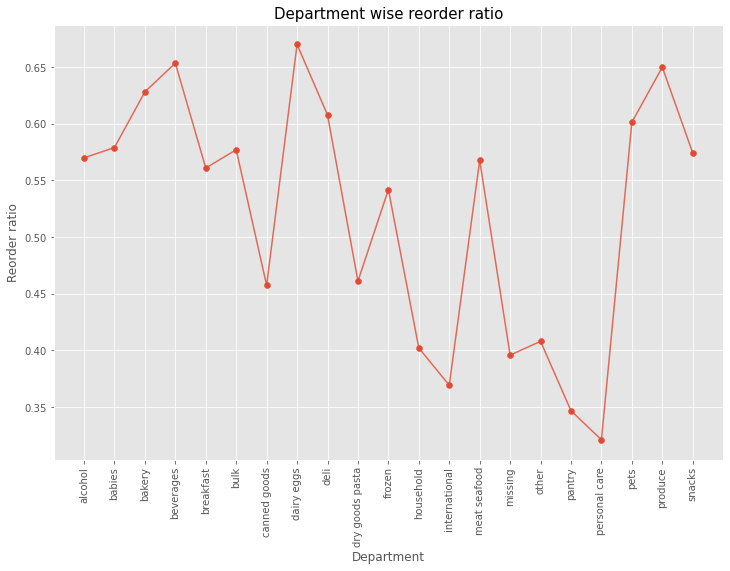

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(list(DFgrouped['department']), DFgrouped['reordered'].values, alpha=0.8)
plt.scatter(list(DFgrouped['department']), DFgrouped['reordered'].values)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
DFtemporary  = order_products__prior.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
DFtemporary  = DFtemporary.sort_values('total', ascending=False).reset_index()

In [ ]:
DFtemporary.head()

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


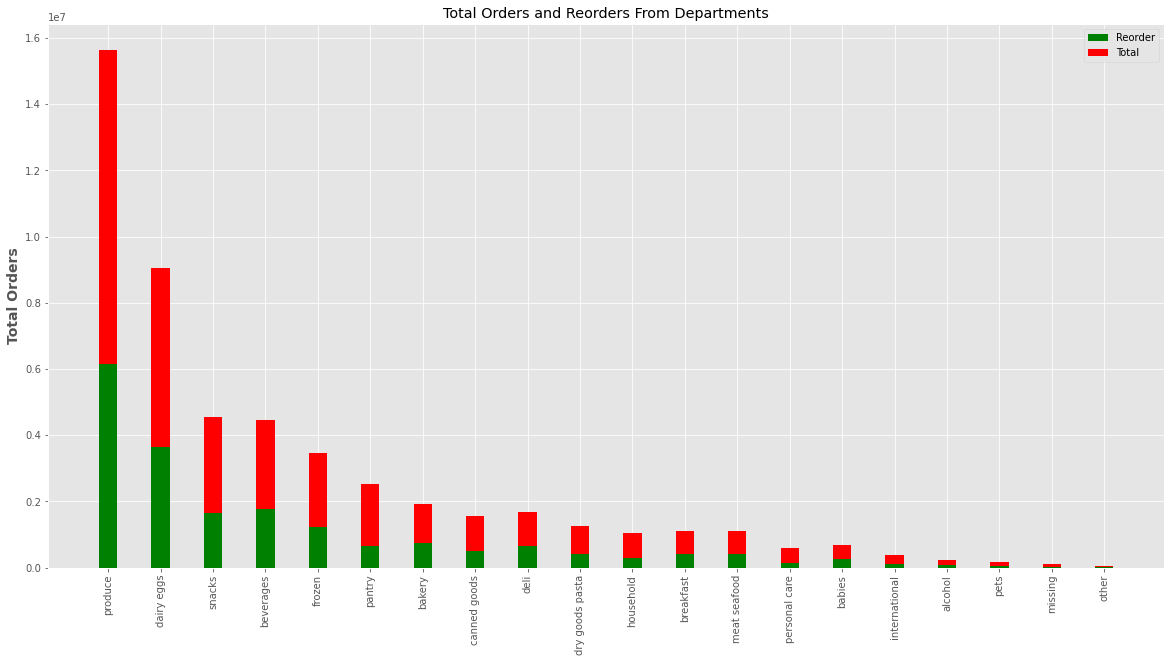

In [ ]:
Label = list(DFtemporary.department[0:20])
ReOrders = list(DFtemporary.reorders[0:20])
TotalReOrder = list(DFtemporary.total[0:20])
Width = 0.35       # the width of the bars: can also be len(x) sequence

figure, axis = plt.subplots(figsize = (20,10))
axis.bar(Label, ReOrders, Width, label='Reorder',color='green')
axis.bar(Label, TotalReOrder, Width, bottom=ReOrders,
       label='Total',color='red')

axis.set_ylabel('Total Orders', fontsize = 14, fontweight = 'bold')
axis.legend()
axis.set_title("Total Orders and Reorders From Departments")
plt.xticks(rotation = 90)
plt.show()

In [ ]:
list(DFgrouped['aisle'])[0:20]

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

In [ ]:
DFgrouped = order_products__prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
DFgrouped.head()

,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


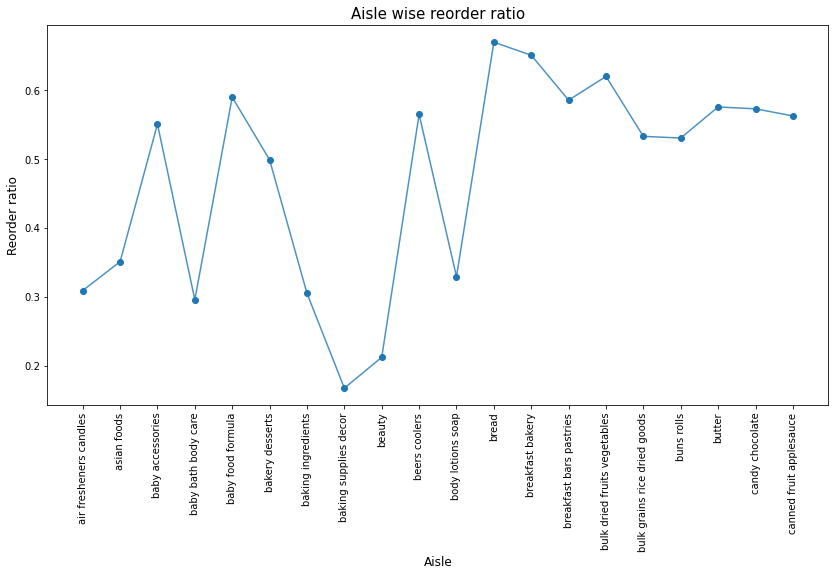

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(list(DFgrouped['aisle'])[0:20], DFgrouped['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(DFgrouped['aisle'])[0:20], DFgrouped['reordered'].values[0:20])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title("Aisle wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
DFtemporary  = order_products__prior.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
DFtemporary  = DFtemporary.sort_values('total', ascending=False).reset_index()

In [ ]:
DFtemporary.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


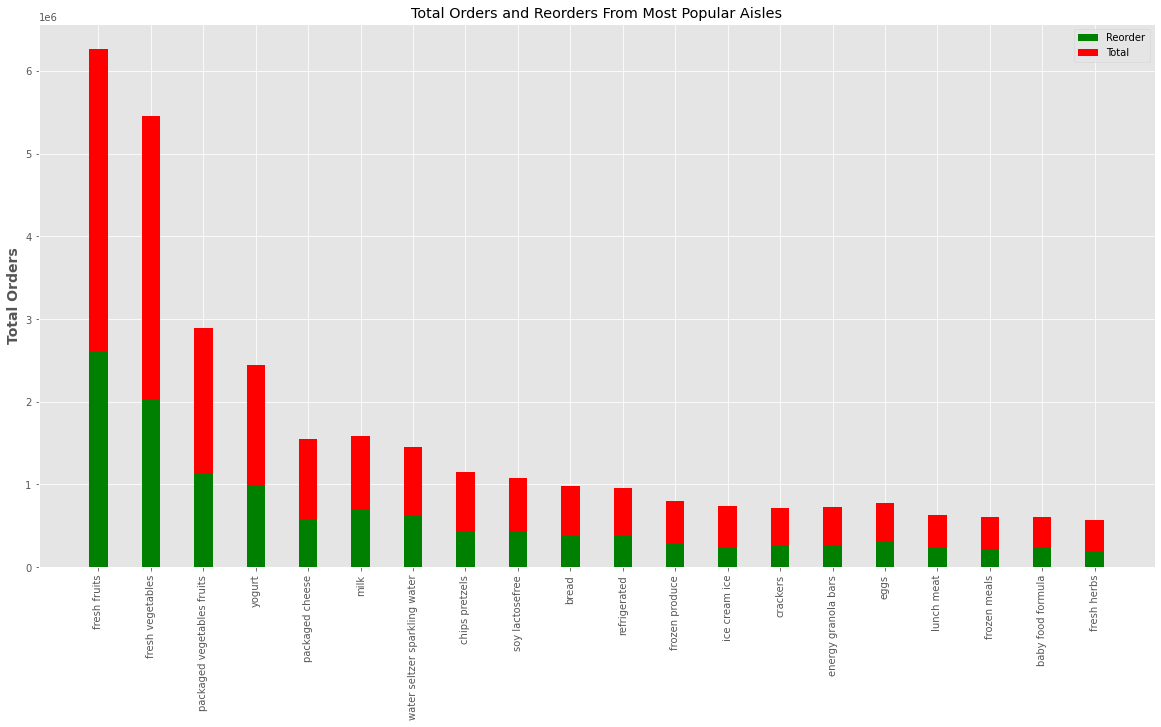

In [ ]:
Label = list(DFtemporary.aisle[0:20])
ReOrders = list(DFtemporary.reorders[0:20])
TotalReOrder = list(DFtemporary.total[0:20])
Width = 0.35       # the width of the bars: can also be len(x) sequence

figure, axis = plt.subplots(figsize = (20,10))
axis.bar(Label, ReOrders, Width, label='Reorder',color='green')
axis.bar(Label, TotalReOrder, Width, bottom=ReOrders,
       label='Total',color='red')

axis.set_ylabel('Total Orders', fontsize = 14, fontweight = 'bold')
axis.legend()
axis.set_title("Total Orders and Reorders From Most Popular Aisles")
plt.xticks(rotation = 90)
plt.show()

### Let us check the relationship between how order of adding the product to the cart affects the reorder ratio

In [ ]:
order_products__prior["add_to_cart_order_mod"] = order_products__prior["add_to_cart_order"].copy()
order_products__prior["add_to_cart_order_mod"].loc[order_products__prior["add_to_cart_order_mod"]>70] = 70
DFgrouped = order_products__prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

/Users/vaishnavimandula/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
DFgrouped.head()

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383


# Implemetation of Apriori

In [ ]:
transactionsTup = [tuple(row) for row in transaction['Products'].tolist()]

### With Support = 0.01 and Confidence = 0.2

In [ ]:
t = datetime.now()
apItemsets, apRules = apriori(transactionsTup[:500000], min_support=0.01, min_confidence=0.2)
print('Execution time : ', datetime.now() - t)

Execution time :  0:02:28.773492


In [ ]:
apRules

[{27966} -> {13176},
 {47209} -> {13176},
 {21137} -> {24852},
 {47766} -> {24852},
 {21903} -> {24852},
 {49683} -> {24852},
 {47626} -> {24852},
 {28204} -> {24852},
 {16797} -> {24852},
 {21903} -> {13176},
 {21137} -> {13176},
 {27966} -> {21137}]

In [ ]:
item1 = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item2 = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temporaryVar = pd.DataFrame()
temporaryVar['itemA'] = item1
temporaryVar['itemB'] = item2

In [ ]:
support1 = []
support2 = []
support12 = []
confidence12 = []
lift12 = []
for i in range(len(temporaryVar)):
    support1.append(apItemsets[1][tuple([temporaryVar['itemA'][i],])] / 500000)
    support2.append(apItemsets[1][tuple([temporaryVar['itemB'][i],])] / 500000)
    if tuple([temporaryVar['itemA'][i],temporaryVar['itemB'][i]]) in apItemsets[2].keys():
        support12.append(apItemsets[2][tuple([temporaryVar['itemA'][i],temporaryVar['itemB'][i]])] / 500000)
    else:
        support12.append(apItemsets[2][tuple([temporaryVar['itemB'][i],temporaryVar['itemA'][i]])] / 500000)
    confidence12.append(support12[i] / support1[i])
    lift12.append(support12[i] / (support1[i] * support2[i]))

In [ ]:
apDfRules = pd.DataFrame()
apDfRules['product_id'] = item1
apDfRules = apDfRules.merge(products, on = 'product_id', how = 'left')
apDfRules['Product_A'] = apDfRules['product_name']
apDfRules = apDfRules.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
apDfRules['product_id'] = item2
apDfRules = apDfRules.merge(products, on = 'product_id', how = 'left')
apDfRules['Product_B'] = apDfRules['product_name']
apDfRules = apDfRules.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
apDfRules['Support_A'] = support1
apDfRules['Support_B'] = support2
apDfRules['Support_AB'] = support12
apDfRules['Confidence_AB'] = confidence12
apDfRules['Lift_AB'] = lift12

In [ ]:
apDfRules.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


In [ ]:
apDfRules.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


### With support = 0.005 and Confidence = 0.2

In [ ]:
t = datetime.now()
apItemsets1, apRules1 = apriori(transactionsTup[:500000], min_support=0.005, min_confidence=0.2)
print('Execution time : ', datetime.now() - t)

Execution time :  0:14:22.080191


In [ ]:
apRules1

[{27966} -> {13176},
 {47209} -> {13176},
 {4605} -> {24852},
 {21137} -> {24852},
 {47766} -> {24852},
 {21903} -> {24852},
 {49683} -> {24852},
 {5876} -> {47209},
 {37646} -> {24852},
 {40706} -> {24852},
 {47626} -> {24852},
 {5876} -> {13176},
 {30391} -> {13176},
 {22935} -> {13176},
 {37646} -> {13176},
 {31717} -> {26209},
 {28204} -> {24852},
 {27845} -> {24852},
 {24964} -> {22935},
 {45066} -> {24852},
 {9076} -> {24852},
 {16797} -> {24852},
 {21903} -> {13176},
 {8277} -> {24852},
 {30391} -> {47209},
 {21137} -> {13176},
 {27966} -> {21137},
 {19057} -> {13176},
 {26209} -> {24852},
 {45007} -> {13176},
 {39275} -> {21137},
 {30489} -> {24852},
 {42265} -> {24852},
 {30391} -> {21137},
 {8277} -> {13176},
 {4920} -> {24852},
 {39275} -> {13176},
 {44632} -> {24852}]

In [ ]:
item1a = [27966,47209,4605,21137,47766,21903,49683,5876,37646,40706,47626,5876,30391,22935,37646,31717,
           28204,27845,24964,45066,9076,16797,21903,8277,30391,21137,27966,19057,26209,45007,39275,30489,
           42265,30391,8277,4920,39275,44632]
item1b = [13176,13176,24852,24852,24852,24852,24852,47209,24852,24852,24852,13176,13176,13176,13176,26209,
           24852,24852,22935,24852,24852,24852,13176,24852,47209,13176,21137,13176,24852,13176,21137,24852,
           24852,21137,13176,24852,13176,24852]
temporaryVar1 = pd.DataFrame()
temporaryVar1['itemA'] = item1a
temporaryVar1['itemB'] = item1b

In [ ]:
support1a = []
support2a = []
support12a = []
confidence12a = []
lift12a = []
for i in range(len(temporaryVar1)):
    support1a.append(apItemsets1[1][tuple([temporaryVar1['itemA'][i],])] / 500000)
    support2a.append(apItemsets1[1][tuple([temporaryVar1['itemB'][i],])] / 500000)
    if tuple([temporaryVar1['itemA'][i],temporaryVar1['itemB'][i]]) in apItemsets1[2].keys():
        support12a.append(apItemsets1[2][tuple([temporaryVar1['itemA'][i],temporaryVar1['itemB'][i]])] / 500000)
    else:
        support12a.append(apItemsets1[2][tuple([temporaryVar1['itemB'][i],temporaryVar1['itemA'][i]])] / 500000)
    confidence12a.append(support12a[i] / support1a[i])
    lift12a.append(support12a[i] / (support1a[i] * support2a[i]))

In [ ]:
apDfRules1 = pd.DataFrame()
apDfRules1['product_id'] = item1a
apDfRules1 = apDfRules1.merge(products, on = 'product_id', how = 'left')
apDfRules1['Product_A'] = apDfRules1['product_name']
apDfRules1 = apDfRules1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
apDfRules1['product_id'] = item1b
apDfRules1 = apDfRules1.merge(products, on = 'product_id', how = 'left')
apDfRules1['Product_B'] = apDfRules1['product_name']
apDfRules1 = apDfRules1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
apDfRules1['Support_A'] = support1a
apDfRules1['Support_B'] = support2a
apDfRules1['Support_AB'] = support12a
apDfRules1['Confidence_AB'] = confidence12a
apDfRules1['Lift_AB'] = lift12a

In [ ]:
apDfRules1.sort_values(by = 'Confidence_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
19,Honeycrisp Apple,Banana,0.024774,0.147194,0.008832,0.356503,2.421993
6,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
4,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
35,Seedless Red Grapes,Banana,0.026054,0.147194,0.007750,0.297459,2.020864
2,Yellow Onions,Banana,0.022814,0.147194,0.006750,0.295871,2.010075
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
20,Blueberries,Banana,0.017674,0.147194,0.005186,0.293425,1.993460
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037


In [ ]:
apDfRules1.sort_values(by = 'Lift_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
15,Organic Cilantro,Limes,0.021334,0.043640,0.005342,0.250398,5.737819
18,Organic Garlic,Organic Yellow Onion,0.034158,0.035306,0.006868,0.201066,5.694942
7,Organic Lemon,Organic Hass Avocado,0.027242,0.066218,0.006534,0.239850,3.622130
24,Organic Cucumber,Organic Hass Avocado,0.025056,0.066218,0.005396,0.215358,3.252252
26,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
30,Organic Blueberries,Organic Strawberries,0.031188,0.082550,0.007284,0.233551,2.829211
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
33,Organic Cucumber,Organic Strawberries,0.025056,0.082550,0.005138,0.205061,2.484078


# Implementation of FP-Growth

### With support = 0.01 and Confidence = 0.2

In [ ]:
supportMin = 0.01 * 500000

t = datetime.now()
pattern = fpg.find_frequent_patterns(transaction['Products'][:500000].tolist(), supportMin)
rule = fpg.generate_association_rules(pattern, 0.2)
print('Execution time : ', datetime.now() - t)

Execution time :  0:02:37.893029


In [ ]:
rule

{(28204,): ((24852,), 0.38043089256316653),
 (49683,): ((24852,), 0.33172281421669203),
 (16797,): ((24852,), 0.2899586479683567),
 (47626,): ((24852,), 0.26597929502493817),
 (47766,): ((24852,), 0.29924492339271314)}

In [ ]:
item1b = [i for i in rule.keys()]
item2b = [i[0] for i in rule.values()]
support1b = []
support2b = []
support12b = []
confidence12b = []
lift12b = []
for i in range(len(item1b)):
    support1b.append(pattern[item1b[i]] / 500000)
    support2b.append(pattern[item2b[i]] / 500000)
    if tuple([list(item1b[i])[0],list(item2b[i])[0]]) in pattern.keys():
        support12b.append( pattern[tuple([list(item1b[i])[0],list(item2b[i])[0]])] / 500000)
    else:
        support12b.append( pattern[tuple([list(item2b[i])[0],list(item1b[i])[0]])] / 500000)
    confidence12b.append(support12b[i] / support1b[i])
    lift12b.append(support12b[i] / (support1b[i] * support2b[i]))

In [ ]:
apDfRules2 = pd.DataFrame()
apDfRules2['product_id'] = [list(i)[0] for i in item1b]
apDfRules2 = apDfRules2.merge(products, on = 'product_id', how = 'left')
apDfRules2['Product_A'] = apDfRules2['product_name']
apDfRules2 = apDfRules2.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
apDfRules2['product_id'] = [list(i)[0] for i in item2b]
apDfRules2 = apDfRules2.merge(products, on = 'product_id', how = 'left')
apDfRules2['Product_B'] = apDfRules2['product_name']
apDfRules2 = apDfRules2.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
apDfRules2['Support_A'] = support1b
apDfRules2['Support_B'] = support2b
apDfRules2['Support_AB'] = support12b
apDfRules2['Confidence_AB'] = confidence12b
apDfRules2['Lift_AB'] = lift12b

In [ ]:
apDfRules2.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
0,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
1,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
4,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
2,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
3,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998


In [ ]:
apDfRules2.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
0,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
1,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
4,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
2,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
3,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998


### With support = 0.005 and Confidence = 0.2

In [ ]:
supportMin = 0.005 * 500000

t = datetime.now()
pattern1 = fpg.find_frequent_patterns(transaction['Products'][:500000].tolist(), supportMin)
rule1 = fpg.generate_association_rules(pattern1, 0.2)
print('Execution time : ', datetime.now() - t)

Execution time :  0:05:12.664917


In [ ]:
rule1

{(9076,): ((24852,), 0.29342537060088264),
 (31717,): ((26209,), 0.2503984250492172),
 (30489,): ((24852,), 0.25601297180434196),
 (4605,): ((24852,), 0.2958709564302621),
 (19057,): ((13176,), 0.3135963035851801),
 (44632,): ((24852,), 0.21126641966992254),
 (42265,): ((24852,), 0.2234416890080429),
 (45066,): ((24852,), 0.3565027851780092),
 (4920,): ((24852,), 0.29745912335917707),
 (28204,): ((24852,), 0.38043089256316653),
 (49683,): ((24852,), 0.33172281421669203)}

In [ ]:
item1c = [i for i in rule1.keys()]
item2c = [i[0] for i in rule1.values()]
support1c = []
support2c = []
support12c = []
confidence12c = []
lift12c = []
for i in range(len(item1c)):
    support1c.append(pattern1[item1c[i]] / 500000)
    if item2c[i] in pattern1.keys():
        support2c.append(pattern1[item2c[i]] / 500000)
    else:
        support2c.append(pattern[item2c[i]] / 500000)
    if tuple([list(item1c[i])[0],list(item2c[i])[0]]) in pattern1.keys():
        support12c.append( pattern1[tuple([list(item1c[i])[0],list(item2c[i])[0]])] / 500000)
    else:
        support12c.append( pattern1[tuple([list(item2c[i])[0],list(item1c[i])[0]])] / 500000)
    confidence12c.append(support12c[i] / support1c[i])
    lift12c.append(support12c[i] / (support1c[i] * support2c[i]))

In [ ]:
apDfRules3 = pd.DataFrame()
apDfRules3['product_id'] = [list(i)[0] for i in item1c]
apDfRules3 = apDfRules3.merge(products, on = 'product_id', how = 'left')
apDfRules3['Product_A'] = apDfRules3['product_name']
apDfRules3 = apDfRules3.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
apDfRules3['product_id'] = [list(i)[0] for i in item2c]
apDfRules3 = apDfRules3.merge(products, on = 'product_id', how = 'left')
apDfRules3['Product_B'] = apDfRules3['product_name']
apDfRules3 = apDfRules3.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
apDfRules3['Support_A'] = support1c
apDfRules3['Support_B'] = support2c
apDfRules3['Support_AB'] = support12c
apDfRules3['Confidence_AB'] = confidence12c
apDfRules3['Lift_AB'] = lift12c

In [ ]:
apDfRules3.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
9,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
7,Honeycrisp Apple,Banana,0.024774,0.147194,0.008832,0.356503,2.421993
10,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
4,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
8,Seedless Red Grapes,Banana,0.026054,0.147194,0.007750,0.297459,2.020864
3,Yellow Onions,Banana,0.022814,0.147194,0.006750,0.295871,2.010075
0,Blueberries,Banana,0.017674,0.147194,0.005186,0.293425,1.993460
2,Original Hummus,Banana,0.022202,0.147194,0.005684,0.256013,1.739289
1,Organic Cilantro,Limes,0.021334,0.043640,0.005342,0.250398,5.737819
6,Organic Baby Carrots,Banana,0.023872,0.147194,0.005334,0.223442,1.518008


In [ ]:
apDfRules3.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
1,Organic Cilantro,Limes,0.021334,0.043640,0.005342,0.250398,5.737819
4,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
9,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
7,Honeycrisp Apple,Banana,0.024774,0.147194,0.008832,0.356503,2.421993
10,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
8,Seedless Red Grapes,Banana,0.026054,0.147194,0.007750,0.297459,2.020864
3,Yellow Onions,Banana,0.022814,0.147194,0.006750,0.295871,2.010075
0,Blueberries,Banana,0.017674,0.147194,0.005186,0.293425,1.993460
2,Original Hummus,Banana,0.022202,0.147194,0.005684,0.256013,1.739289
6,Organic Baby Carrots,Banana,0.023872,0.147194,0.005334,0.223442,1.518008


# Recommender System

In [ ]:
from surprise import KNNBasic, SVD, Reader, accuracy, Dataset
from surprise.model_selection import cross_validate, train_test_split
from collections import defaultdict

In [ ]:
trainMatrix = order_product_train[['user_id','product_name']].iloc[:500000,:]
trainMatrix['rating'] = 1

In [ ]:
trainMatrix.head()

,user_id,product_name,rating
0,112108,Bulgarian Yogurt,1
1,112108,Organic 4% Milk Fat Whole Milk Cottage Cheese,1
2,112108,Organic Celery Hearts,1
3,112108,Cucumber Kirby,1
4,112108,Lightly Smoked Sardines in Olive Oil,1


In [ ]:
r = Reader()
trainData = Dataset.load_from_df(trainMatrix[['user_id', 'product_name', 'rating']], r)

In [ ]:
trainX, testX = train_test_split(trainData, test_size = 0.25, random_state = 0)

# Collaborative Filtering

In [ ]:
def gettingTopN(predictions, n):
    # First map the predictions to each user.
    topN = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        topN[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in topN.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        topN[uid] = user_ratings[:n]

    return topN

## PMF

In [ ]:
# PMF model
pmfSVD = SVD(biased = False)

In [ ]:
pmfCV = cross_validate(pmfSVD, trainData, cv = 5, )

In [ ]:
pmfSVD.fit(trainX)

In [ ]:
pmfPrediction = pmfSVD.test(testX)
accuracy.mae(pmfPrediction)
accuracy.rmse(pmfPrediction)

MAE:  0.0019
RMSE: 0.0182


0.018222349534105484

### Top n Recommendations

In [ ]:
trainMatrix[trainMatrix['user_id'] == 112108]

,user_id,product_name,rating
0,112108,Bulgarian Yogurt,1
1,112108,Organic 4% Milk Fat Whole Milk Cottage Cheese,1
2,112108,Organic Celery Hearts,1
3,112108,Cucumber Kirby,1
4,112108,Lightly Smoked Sardines in Olive Oil,1
5,112108,Bag of Organic Bananas,1
6,112108,Organic Hass Avocado,1
7,112108,Organic Whole String Cheese,1


In [ ]:
trainMatrix[trainMatrix['user_id'] == 1]

,user_id,product_name,rating
484420,1,Soda,1
484421,1,Organic String Cheese,1
484422,1,0% Greek Strained Yogurt,1
484423,1,XL Pick-A-Size Paper Towel Rolls,1
484424,1,Milk Chocolate Almonds,1
484425,1,Pistachios,1
484426,1,Cinnamon Toast Crunch,1
484427,1,Aged White Cheddar Popcorn,1
484428,1,Organic Whole Milk,1
484429,1,Organic Half & Half,1


In [ ]:
topN = gettingTopN(pmfPrediction, 10)

pmf_pred_dict = {}
for uid, user_ratings in topN.items():
    pmf_pred_dict[uid] = [iid for (iid, _) in user_ratings]

In [ ]:
pmf_pred_dict[112108]

['Organic 4% Milk Fat Whole Milk Cottage Cheese',
 'Lightly Smoked Sardines in Olive Oil']

In [ ]:
pmf_pred_dict[1]

['Organic String Cheese',
 'Cinnamon Toast Crunch',
 'Aged White Cheddar Popcorn']

## User based CF

In [ ]:
cfUserBased = KNNBasic(sim_options={'user_based': True, 'name' : 'cosine'}, verbose = True)

In [ ]:
cfUserBased.fit(trainX)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
ubPrediction = cfUserBased.test(testX)
accuracy.mae(ubPrediction)
accuracy.rmse(ubPrediction)

MAE:  0.0000
RMSE: 0.0000


0.0

### Top N Recommendations

In [ ]:
topN = gettingTopN(ubPrediction, 10)

ub_pred_dict = {}
for uid, user_ratings in topN.items():
    ub_pred_dict[uid] = [iid for (iid, _) in user_ratings]

In [ ]:
ub_pred_dict[112108]

['Organic 4% Milk Fat Whole Milk Cottage Cheese',
 'Lightly Smoked Sardines in Olive Oil']

In [ ]:
ub_pred_dict[1]

['Organic String Cheese',
 'Cinnamon Toast Crunch',
 'Aged White Cheddar Popcorn']

## Item based CF

In [ ]:
cfItemBased = KNNBasic(sim_options={'user_based': False, 'name' : 'cosine'}, verbose = True)

In [ ]:
cfItemBased.fit(trainX)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
ibPrediction = cfItemBased.test(testX)
accuracy.mae(ibPrediction)
accuracy.rmse(ibPrediction)

MAE:  0.0000
RMSE: 0.0000


0.0

### Top N Recommendations

In [ ]:
topN = gettingTopN(ibPrediction, 10)

ib_pred_dict = {}
for uid, user_ratings in topN.items():
    ib_pred_dict[uid] = [iid for (iid, _) in user_ratings]

In [ ]:
ib_pred_dict[1]

['Organic String Cheese',
 'Cinnamon Toast Crunch',
 'Aged White Cheddar Popcorn']

In [ ]:
ib_pred_dict[112108]

['Organic 4% Milk Fat Whole Milk Cottage Cheese',
 'Lightly Smoked Sardines in Olive Oil']

# Classification Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, plot_confusion_matrix

In [ ]:
DataSet = order_products__train.copy(deep = True)
DataSet.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [ ]:
DataSet.drop(['eval_set','product_name','aisle','department'],axis=1,inplace=True)

In [ ]:
DataSet.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
aisle_id                  0
department_id             0
dtype: int64

In [ ]:
DataSet.corr()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
order_id,1.000000,-0.000545,0.001916,0.001418,-0.000867,0.001522,0.001090,-0.004422,0.002708,-0.000814,0.002708
product_id,-0.000545,1.000000,0.003128,0.006560,-0.001014,-0.001463,-0.003597,0.001829,0.001036,-0.001932,-0.027212
add_to_cart_order,0.001916,0.003128,1.000000,-0.146393,0.000739,0.014332,-0.019353,-0.008905,0.017283,0.010887,0.027428
reordered,0.001418,0.006560,-0.146393,1.000000,-0.004316,0.223947,-0.006714,-0.017840,-0.160152,-0.000172,-0.050294
user_id,-0.000867,-0.001014,0.000739,-0.004316,1.000000,-0.003715,-0.006746,-0.001239,0.003854,0.000972,-0.000548
order_number,0.001522,-0.001463,0.014332,0.223947,-0.003715,1.000000,0.024500,-0.026567,-0.403861,-0.002022,-0.001568
order_dow,0.001090,-0.003597,-0.019353,-0.006714,-0.006746,0.024500,1.000000,0.005910,-0.026765,-0.002933,0.006798
order_hour_of_day,-0.004422,0.001829,-0.008905,-0.017840,-0.001239,-0.026567,0.005910,1.000000,0.005184,-0.001078,-0.005992
days_since_prior_order,0.002708,0.001036,0.017283,-0.160152,0.003854,-0.403861,-0.026765,0.005184,1.000000,0.006088,0.005045
aisle_id,-0.000814,-0.001932,0.010887,-0.000172,0.000972,-0.002022,-0.002933,-0.001078,0.006088,1.000000,0.061357


In [ ]:
xAxis = DataSet.drop(['reordered','user_id','order_id','aisle_id'], axis = 1).iloc[:,:].values
yAxis = DataSet['reordered'].values

In [ ]:
trainX, testX, trainY, testY = train_test_split(xAxis, yAxis, test_size = 0.25, random_state = 0)

In [ ]:
nz = Normalizer()
nz.fit(trainX)
trainX = nz.transform(trainX)
testX = nz.transform(testX)

### Logistic Regression

In [ ]:
LRClassifier = LogisticRegression(random_state = 0, n_jobs = -1, max_iter = 100000)
LRClassifier.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=0,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
LRyPred = LRClassifier.predict(testX)
print('accuracy : ', accuracy_score(testY, LRyPred))
print('log_loss : ', log_loss(testY, LRyPred))

accuracy :  0.5988646704510985
log_loss :  13.855042761384036


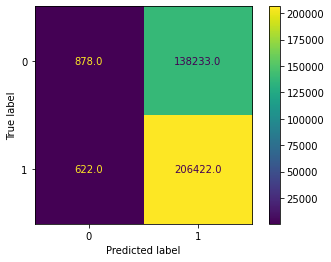

In [ ]:
print(plot_confusion_matrix(LRClassifier,testX, testY, values_format = '.1f'))

In [ ]:
print(classification_report(testY, LRyPred))

              precision    recall  f1-score   support

           0       0.59      0.01      0.01    139111
           1       0.60      1.00      0.75    207044

    accuracy                           0.60    346155
   macro avg       0.59      0.50      0.38    346155
weighted avg       0.59      0.60      0.45    346155



### Random Forest

In [ ]:
RFClassifier = RandomForestClassifier(random_state = 0, n_jobs = -1)
RFClassifier.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
RFyPred = RFClassifier.predict(testX)
print('accuracy : ', accuracy_score(testY, RFyPred))
print('log_loss : ', log_loss(testY, RFyPred))

accuracy :  0.6557553697043232
log_loss :  11.889961498714957


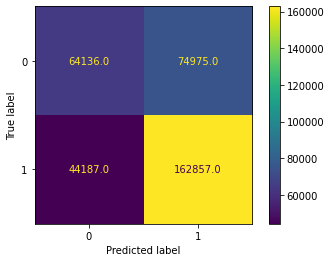

In [ ]:
print(plot_confusion_matrix(RFClassifier,testX, testY, values_format = '.1f'))

In [ ]:
print(classification_report(testY, RFyPred))

              precision    recall  f1-score   support

           0       0.59      0.46      0.52    139111
           1       0.68      0.79      0.73    207044

    accuracy                           0.66    346155
   macro avg       0.64      0.62      0.63    346155
weighted avg       0.65      0.66      0.65    346155



### AdaBoost

In [ ]:
AdaClassifier = AdaBoostClassifier(random_state = 0)
AdaClassifier.fit(trainX, trainY)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=0)

In [ ]:
ADAyPred = AdaClassifier.predict(testX)
print('accuracy : ', accuracy_score(testY, ADAyPred))
print('log_loss : ', log_loss(testY, ADAyPred))

accuracy :  0.6215741503083878
log_loss :  13.070619747854048


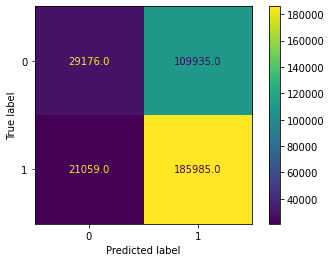

In [ ]:
print(plot_confusion_matrix(AdaClassifier,testX, testY, values_format = '.1f'))

In [ ]:
print(classification_report(testY, ADAyPred))

              precision    recall  f1-score   support

           0       0.58      0.21      0.31    139111
           1       0.63      0.90      0.74    207044

    accuracy                           0.62    346155
   macro avg       0.60      0.55      0.52    346155
weighted avg       0.61      0.62      0.57    346155



### GradientBoost

In [ ]:
GDClassifier = GradientBoostingClassifier(random_state = 0)
GDClassifier.fit(trainX, trainY)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
GDyPred = GDClassifier.predict(testX)
print('accuracy : ', accuracy_score(testY, GDyPred))
print('log_loss : ', log_loss(testY, GDyPred))

accuracy :  0.6466438445205183
log_loss :  12.204710716649778


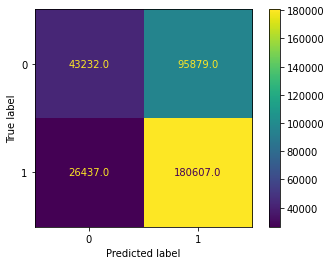

In [ ]:
print(plot_confusion_matrix(GDClassifier,testX, testY, values_format = '.1f'))

In [ ]:
print(classification_report(testY, GDyPred))

              precision    recall  f1-score   support

           0       0.62      0.31      0.41    139111
           1       0.65      0.87      0.75    207044

    accuracy                           0.65    346155
   macro avg       0.64      0.59      0.58    346155
weighted avg       0.64      0.65      0.61    346155



### Linear SVM

In [ ]:
LSVMClassifier = LinearSVC(random_state = 0, max_iter = 100000)
LSVMClassifier.fit(trainX, trainY)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [ ]:
LSVMyPred = LSVMClassifier.predict(testX)
print('accuracy : ', accuracy_score(testY, LSVMyPred))
print('log_loss : ', log_loss(testY, LSVMyPred))

accuracy :  0.5987115598503561
log_loss :  13.86033153392337


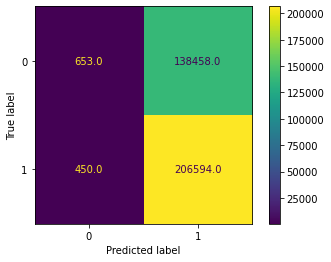

In [ ]:
print(plot_confusion_matrix(LSVMClassifier,testX, testY, values_format = '.1f'))

In [ ]:
print(classification_report(testY, LSVMyPred))

              precision    recall  f1-score   support

           0       0.59      0.00      0.01    139111
           1       0.60      1.00      0.75    207044

    accuracy                           0.60    346155
   macro avg       0.60      0.50      0.38    346155
weighted avg       0.60      0.60      0.45    346155



### Naive Bayes

In [ ]:
NBClassifier = GaussianNB()
NBClassifier.fit(trainX, trainY)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
NByPred = NBClassifier.predict(testX)
print('accuracy : ', accuracy_score(testY, NByPred))
print('log_loss : ', log_loss(testY, NByPred))

accuracy :  0.5991131140673975
log_loss :  13.84645881764144


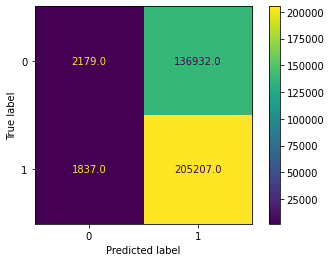

In [ ]:
print(plot_confusion_matrix(NBClassifier,testX, testY, values_format = '.1f'))

In [ ]:
print(classification_report(testY, NByPred))

              precision    recall  f1-score   support

           0       0.54      0.02      0.03    139111
           1       0.60      0.99      0.75    207044

    accuracy                           0.60    346155
   macro avg       0.57      0.50      0.39    346155
weighted avg       0.58      0.60      0.46    346155



### KNN

In [ ]:
KNNClassifier = KNeighborsClassifier(n_neighbors = 7)
KNNClassifier.fit(trainX, trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [ ]:
KNNyPred = KNNClassifier.predict(testX)
print('accuracy : ', accuracy_score(testY, KNNyPred))
print('log_loss : ', log_loss(testY, KNNyPred))

accuracy :  0.628634571218096
log_loss :  12.826683192637734


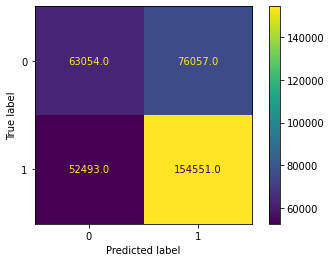

In [ ]:
print(plot_confusion_matrix(KNNClassifier,testX, testY, values_format = '.1f'))

In [ ]:
print(classification_report(testY, KNNyPred))

              precision    recall  f1-score   support

           0       0.55      0.45      0.50    139111
           1       0.67      0.75      0.71    207044

    accuracy                           0.63    346155
   macro avg       0.61      0.60      0.60    346155
weighted avg       0.62      0.63      0.62    346155



### ANN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

In [ ]:
ANN = Sequential()
ANN.add(Dense(units = 30, activation = 'relu'))
ANN.add(Dropout(0.2))
ANN.add(Dense(units = 30, activation = 'relu'))
ANN.add(Dropout(0.2))
ANN.add(Dense(units = 20, activation = 'relu'))
ANN.add(Dropout(0.2))
ANN.add(Dense(units = 1, activation = 'sigmoid'))
ANN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
ANN.fit(trainX, trainY, epochs = 50, batch_size = 32)

Epoch 1/50
32452/32452 [==============================] - 51s 2ms/step - loss: 0.6728 - accuracy: 0.5991
Epoch 2/50
32452/32452 [==============================] - 50s 2ms/step - loss: 0.6496 - accuracy: 0.6159
Epoch 3/50
32452/32452 [==============================] - 50s 2ms/step - loss: 0.6433 - accuracy: 0.6219
Epoch 4/50
32452/32452 [==============================] - 50s 2ms/step - loss: 0.6409 - accuracy: 0.6262
Epoch 5/50
32452/32452 [==============================] - 50s 2ms/step - loss: 0.6383 - accuracy: 0.6300
Epoch 6/50
32452/32452 [==============================] - 50s 2ms/step - loss: 0.6366 - accuracy: 0.6320
Epoch 7/50
32452/32452 [==============================] - 50s 2ms/step - loss: 0.6359 - accuracy: 0.6342
Epoch 8/50
32452/32452 [==============================] - 50s 2ms/step - loss: 0.6350 - accuracy: 0.6352
Epoch 9/50
32452/32452 [==============================] - 50s 2ms/step - loss: 0.6344 - accuracy: 0.6366
Epoch 10/50
32452/32452 [==============================

In [ ]:
ANNyPred = ANN.predict(testX)
ANNyPred = [1 if i>=0.5 else 0 for i in ANNyPred]
print('accuracy : ', accuracy_score(testY, ANNyPred))
print('log_loss : ', log_loss(testY, ANNyPred))

accuracy :  0.6529444901850328
log_loss :  11.98705999090979


In [ ]:
print(classification_report(testY, ANNyPred))

              precision    recall  f1-score   support

           0       0.60      0.42      0.49    139111
           1       0.67      0.81      0.74    207044

    accuracy                           0.65    346155
   macro avg       0.64      0.61      0.61    346155
weighted avg       0.64      0.65      0.64    346155

